In [328]:
import polars as pl
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVR, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from itertools import product
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [329]:
sns.set(rc={
    'figure.figsize':(12,10),
})

plt.style.use("Solarize_Light2")

In [330]:
tracks_lf = pl.scan_csv('data/music-info-clean.csv').with_columns(
    pl.col('genres').str.split(';').alias('genres')
)

In [331]:
tracks_slice_lf = tracks_lf.filter(
    pl.col('playcount').is_between(
        pl.col('playcount').quantile(0.55),
        pl.col('playcount').quantile(0.6)
    )
).sort(by='playcount', descending=True)

tracks_slice_lf.limit(20).collect()

track_id,name,artist,spotify_preview_url,spotify_id,year,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genres,playcount
str,str,str,str,str,i64,i64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,i64,list[str],i64
"""TRPTZLC128F92E…","""North Sea Stor…","""Amon Amarth""","""https://p.scdn…","""0uB7jXX84Ipd2v…",1999,296026,0.345,0.989,4,-3.768,1,0.0716,0.000003,0.835,0.272,0.0471,142.189,4,"[""melodic_death_metal"", ""rock"", ""death_metal""]",252
"""TRTLVSS128E078…","""Oompa Radar""","""Goldfrapp""","""https://p.scdn…","""1f20trxXqODnys…",2000,282333,0.406,0.44,5,-13.63,0,0.0391,0.767,0.235,0.16,0.143,78.559,3,"[""electronic"", ""ambient"", … ""downtempo""]",252
"""TRWPIIN12903CD…","""Stop Loving Yo…","""Toto""","""https://p.scdn…","""0Fgc66iBdbKSL9…",1978,267933,0.574,0.649,5,-12.744,1,0.0302,0.226,0.0228,0.0569,0.583,101.728,4,"[""rock"", ""classic_rock"", … ""pop_rock""]",252
"""TRWPOEL128F935…","""Losing Faith""","""Arch Enemy""","""https://p.scdn…","""42aaPLPZA6lieV…",1996,184866,0.236,0.989,7,-4.274,1,0.23,0.0000149,0.867,0.126,0.187,95.259,4,"[""melodic_death_metal"", ""swedish""]",252
"""TRMKFVB12903CA…","""Heartsink""","""Blood Red Shoe…","""https://p.scdn…","""0ieaN90XoLvpqI…",2010,221889,0.474,0.995,11,-4.277,0,0.19,0.0000167,0.0115,0.364,0.293,142.051,4,"[""indie"", ""post_punk"", … ""indie_rock""]",252
"""TRKAHAM128E078…","""I Ain't Saying…","""Tom Vek""","""https://p.scdn…","""02fEWccTO0HiKV…",2005,224293,0.611,0.885,2,-2.219,1,0.125,0.0501,0.00481,0.107,0.581,137.997,4,"[""electro"", ""rock"", … ""indie""]",252
"""TRGBEVR128F92C…","""Cores""","""Da Lata""","""https://p.scdn…","""1t8M8YLGUhXajZ…",2010,209626,0.409,0.435,5,-12.155,0,0.0826,0.232,0.000162,0.122,0.423,100.064,4,"[""chillout"", ""lounge""]",252
"""TRNHIZO128F935…","""Hit the Plane …","""Pavement""","""https://p.scdn…","""04nEicqsGqjHpN…",1994,216733,0.449,0.84,5,-9.147,1,0.0585,0.54,0.199,0.426,0.564,97.591,4,"[""90s"", ""downtempo"", … ""alternative""]",252
"""TRILUPL128F930…","""Pessimist""","""Wild Nothing""","""https://p.scdn…","""0HpCv71nioUPwo…",2010,107235,0.33,0.509,0,-11.437,1,0.0358,0.775,0.975,0.0973,0.142,90.566,4,"[""love"", ""indie_pop"", … ""downtempo""]",252


In [332]:
tracks_slice_lf.select('playcount').collect().describe()

describe,playcount
str,f64
"""count""",1510.0
"""null_count""",0.0
"""mean""",217.370861
"""std""",19.215397
"""min""",187.0
"""max""",252.0
"""median""",216.0
"""25%""",200.0
"""75%""",233.0


In [333]:
df = tracks_slice_lf.collect().to_pandas()

In [334]:
tracks_slice_lf.columns

['track_id',
 'name',
 'artist',
 'spotify_preview_url',
 'spotify_id',
 'year',
 'duration_ms',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'genres',
 'playcount']

In [335]:
features = [
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo'
]

target = 'playcount'

feature_columns = [pl.col(feature) for feature in features]
tracks_slice_lf.select(feature_columns).fetch(1)

danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
f64,f64,f64,f64,f64,f64,f64,f64,f64
0.554,0.49,-8.046,0.0457,0.0168,0.000534,0.136,0.513,84.275


In [336]:
tracks_slice_lf.with_columns(pl.col(target).cast(pl.Float64)).select([pl.corr(col, pl.col(target)) for col in feature_columns]).collect()

danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
f64,f64,f64,f64,f64,f64,f64,f64,f64
0.020843,-0.054604,-0.050637,-0.023055,0.061338,0.006344,0.020901,0.033274,-0.040799


In [337]:
tracks_slice_nums_lf = tracks_slice_lf.select(feature_columns)
corr_matrix = tracks_slice_nums_lf.collect().corr()
corr_matrix

danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,-0.145554,-0.040293,0.02643,0.082022,-0.091904,-0.103155,0.524121,-0.1473
-0.145554,1.0,0.796619,0.218094,-0.73054,-0.159721,0.142736,0.114523,0.23986
-0.040293,0.796619,1.0,0.131725,-0.625937,-0.329574,0.068663,0.130501,0.198957
0.02643,0.218094,0.131725,1.0,-0.111863,-0.090761,0.144365,0.007245,0.026413
0.082022,-0.73054,-0.625937,-0.111863,1.0,0.123516,-0.053367,-0.076899,-0.227304
-0.091904,-0.159721,-0.329574,-0.090761,0.123516,1.0,-0.022388,-0.211992,-0.061623
-0.103155,0.142736,0.068663,0.144365,-0.053367,-0.022388,1.0,-0.050916,0.02854
0.524121,0.114523,0.130501,0.007245,-0.076899,-0.211992,-0.050916,1.0,0.044491
-0.1473,0.23986,0.198957,0.026413,-0.227304,-0.061623,0.02854,0.044491,1.0


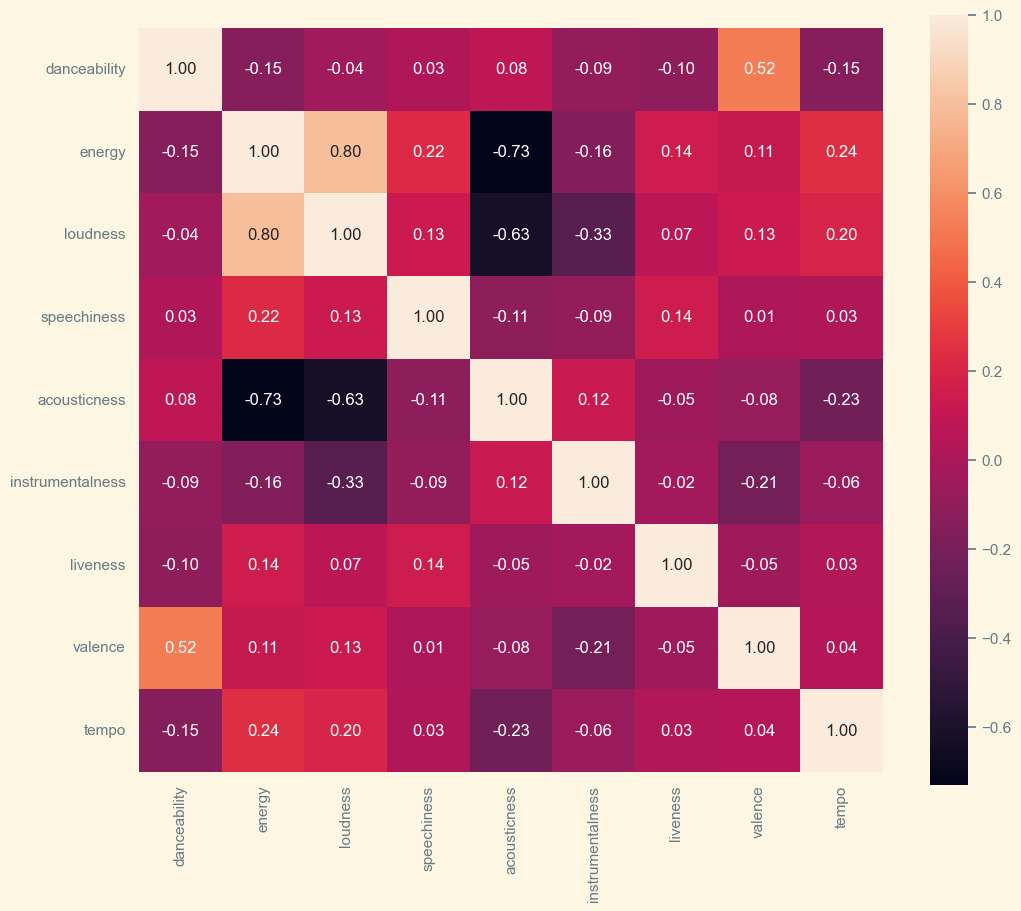

In [338]:
sns.heatmap(corr_matrix, square=True, annot=True, fmt='.2f', xticklabels=features, yticklabels=features)
plt.show()

In [339]:
sampled = tracks_slice_lf.collect().sample(1000)

X = sampled.select(feature_columns).to_numpy()
y = sampled.select(pl.col(target)).to_numpy().ravel()

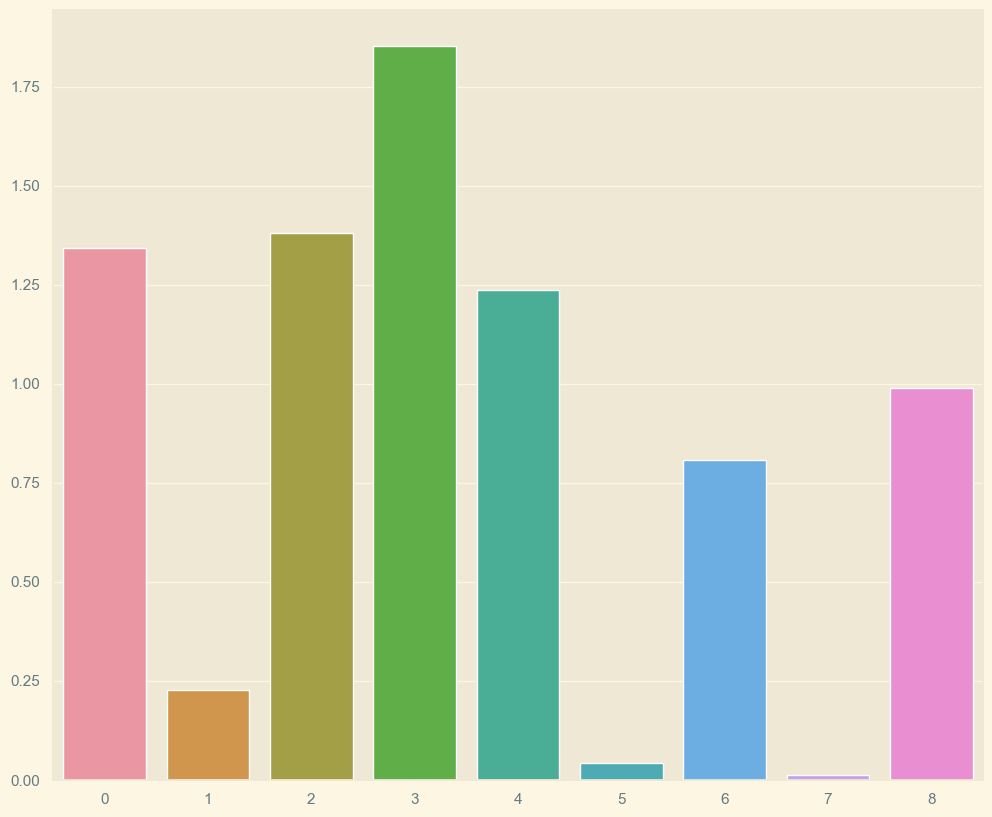

In [340]:
def select_features(X_train, y_train, X_test, func):
    fs = SelectKBest(score_func=func, k='all')
    fs.fit(X_train, y_train)
    return fs.transform(X_train), fs.transform(X_test), fs

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, f_regression)

sns.barplot(x=[i for i in range(len(fs.scores_))], y=fs.scores_)
plt.show()

In [341]:
sel = SelectKBest(f_regression, k=4)
X_selected = sel.fit_transform(X, y)

In [342]:
def param_tuning(model, params_kw):
    combinations = list(product(*[value for value in params_kw.values()]))
    models = []
    for combination in combinations:
        params = {}
        for i, key in enumerate(params_kw.keys()):
            params[key] = combination[i]
        models.append(model().set_params(**dict(params)))
    return models

param_tuning(SVR, {
    'C': [1, 2],
    'kernel': ['linear', 'poly']
})

[SVR(C=1, kernel='linear'),
 SVR(C=1, kernel='poly'),
 SVR(C=2, kernel='linear'),
 SVR(C=2, kernel='poly')]

In [343]:
def test_model(model, X_train, X_test, y_train, y_test):
    clf  = model.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return score

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, train_size=0.2)

results = {
    'name': [],
    'r2': []
}
for clf in param_tuning(KNeighborsRegressor, {'n_neighbors': list(range(3, 30))}) +\
    param_tuning(SVR, {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}) +\
    param_tuning(SGDRegressor, {'alpha': [0.001 ,0.01, 0.1, 1, 10, 100]}) +\
    [LinearRegression()]:

    results['name'].append(str(clf))
    results['r2'].append(test_model(clf, X_train, X_test, y_train, y_test))

regression = pl.DataFrame(results)
regression.sort(by='r2', descending=True).limit(5)

name,r2
str,f64
"""SVR(C=0.01, ke…",-0.000135
"""SVR(C=0.1)""",-0.000145
"""SVR(C=1)""",-0.000148
"""SVR(C=0.01)""",-0.000188
"""SVR(C=0.01, ke…",-0.000203


Regression does not yield satisfying results, as the track popularity does not seem to be connected in any way to any measurable musical attributes.

In [344]:
genres = [
    'pop',
    'rock',
    'electronic',
    'metal'
]

df = tracks_lf.explode('genres').filter(
    pl.col('genres').is_in(genres)
).groupby('name').count().filter(
    pl.col('count') == 1
).select(pl.all().exclude('count')).join(tracks_lf, on='name').rename({'genres': 'genre'}).explode('genre').filter(
    pl.col('genre').is_in(genres)
).collect()
df.limit(5)

name,track_id,artist,spotify_preview_url,spotify_id,year,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre,playcount
str,str,str,str,str,i64,i64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,i64,str,i64
"""Stairway to He…","""TRUOEWJ128F934…","""Led Zeppelin""","""https://p.scdn…","""03hLW9osM6UuNq…",2013,488019,0.354,0.361,9,-12.722,0,0.0509,0.625,0.0112,0.35,0.212,80.36,4,"""rock""",566
"""Where Is My Mi…","""TRNNGMK128F423…","""Pixies""","""https://p.scdn…","""0DJU6KGwdkxEPC…",2005,230093,0.514,0.435,4,-13.517,1,0.0353,0.0078,0.000859,0.0802,0.212,82.104,4,"""rock""",32185
"""Heart-Shaped B…","""TRADPIA128E078…","""Nirvana""","""https://p.scdn…","""0FMu3Z1yvTJKLW…",2007,278520,0.609,0.842,0,-5.861,1,0.0342,0.0044,0.0116,0.353,0.459,115.158,4,"""rock""",210
"""In Bloom""","""TRSFPEE128F429…","""Nirvana""","""https://p.scdn…","""2qdRHMosT8YO3z…",1991,254760,0.433,0.744,10,-8.97,0,0.0449,0.00001,0.0000773,0.29,0.595,157.18,4,"""rock""",41
"""Float On""","""TRPFYYL128F92F…","""Modest Mouse""","""https://p.scdn…","""1Urf1M52P3R6NY…",2004,208466,0.646,0.893,6,-4.799,1,0.0301,0.0151,0.000004,0.0892,0.559,100.951,4,"""rock""",85079


In [345]:
sampled = df.sample(1000)
target = 'genre'

X = sampled.select(feature_columns).to_numpy()
y = sampled.select(pl.col(target)).to_numpy().ravel()

In [346]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X, y)

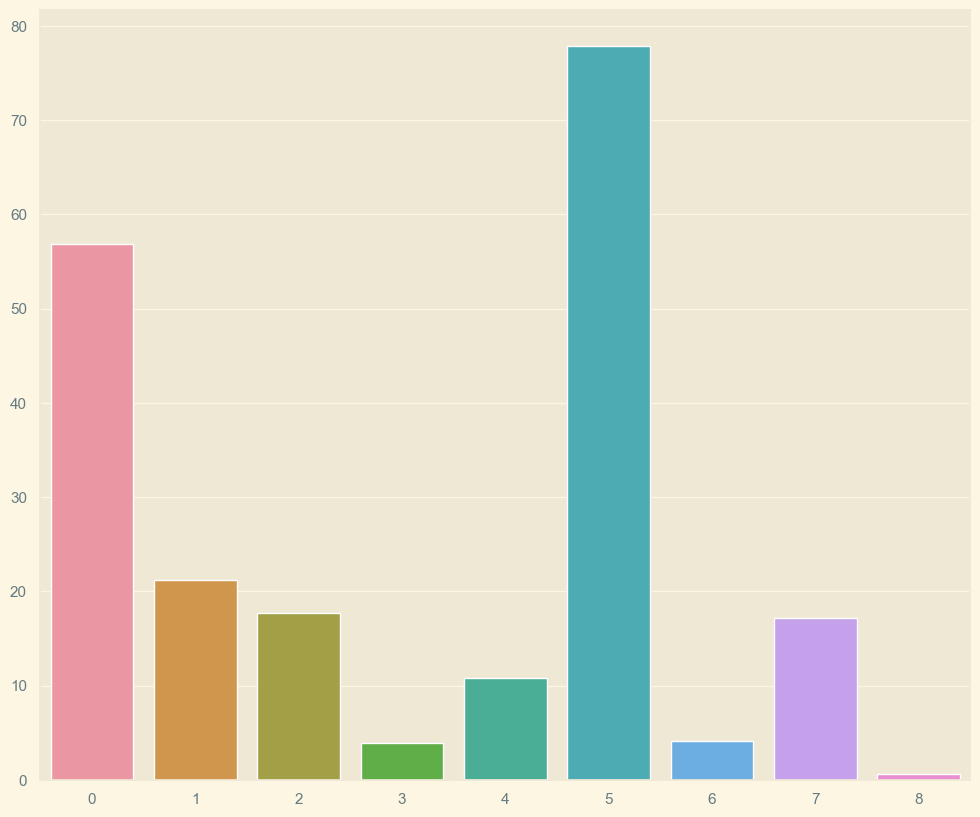

In [347]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, f_classif)

sns.barplot(x=[i for i in range(len(fs.scores_))], y=fs.scores_)
plt.show()

In [348]:
N = 3
sel = SelectKBest(f_classif, k=N)
X_selected = sel.fit_transform(X_scaled, y)

In [350]:
label_encoder = LabelEncoder()
y_num = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y_num, train_size=0.2)

In [352]:
results = {
    'name': [],
    'accuracy': []
}

for clf in param_tuning(KNeighborsClassifier, {'n_neighbors': list(range(3, 30))}) +\
       param_tuning(SVC, {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}) +\
       [GaussianNB()]:
    results['name'].append(str(clf))
    results['accuracy'].append(test_model(clf, X_train, X_test, y_train, y_test))

classification = pl.DataFrame(results)
classification.sort(by='accuracy', descending=True).limit(5)

name,accuracy
str,f64
"""GaussianNB()""",0.635
"""SVC(C=1, kerne…",0.6225
"""SVC(C=10, kern…",0.6225
"""SVC(C=100, ker…",0.6225
"""KNeighborsClas…",0.62125


In [369]:
model = Sequential([
    layers.Dense(428, activation='relu', input_shape=(X_selected.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(214, activation='sigmoid'),
    layers.Dropout(0.2),
    layers.Dense(len(genres), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_crossentropy', 'accuracy']
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 428)               1712      
                                                                 
 dropout_14 (Dropout)        (None, 428)               0         
                                                                 
 dense_22 (Dense)            (None, 214)               91806     
                                                                 
 dropout_15 (Dropout)        (None, 214)               0         
                                                                 
 dense_23 (Dense)            (None, 4)                 860       
                                                                 
Total params: 94,378
Trainable params: 94,378
Non-trainable params: 0
_________________________________________________________________


In [370]:
model.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1)

Epoch 1/10
2/2 [==============================] - 1s 7ms/step - loss: 1.7679 - sparse_categorical_crossentropy: 1.7679 - accuracy: 0.1000
Epoch 2/10
2/2 [==============================] - 0s 9ms/step - loss: 1.5463 - sparse_categorical_crossentropy: 1.5463 - accuracy: 0.1900
Epoch 3/10
2/2 [==============================] - 0s 8ms/step - loss: 1.3656 - sparse_categorical_crossentropy: 1.3656 - accuracy: 0.3150
Epoch 4/10
2/2 [==============================] - 0s 7ms/step - loss: 1.2336 - sparse_categorical_crossentropy: 1.2336 - accuracy: 0.4600
Epoch 5/10
2/2 [==============================] - 0s 10ms/step - loss: 1.2115 - sparse_categorical_crossentropy: 1.2115 - accuracy: 0.5000
Epoch 6/10
2/2 [==============================] - 0s 9ms/step - loss: 1.1423 - sparse_categorical_crossentropy: 1.1423 - accuracy: 0.5450
Epoch 7/10
2/2 [==============================] - 0s 7ms/step - loss: 1.1401 - sparse_categorical_crossentropy: 1.1401 - accuracy: 0.5750
Epoch 8/10
2/2 [=================

In [379]:
evaluation = model.evaluate(X_test, y_test)
result = evaluation[2]

25/25 [==============================] - 0s 4ms/step - loss: 1.0507 - sparse_categorical_crossentropy: 1.0507 - accuracy: 0.6125
